# Итоговое задание юнита 4
# Авиарейсы без потерь

Проект посвящён анализу рентабельности авиарейсов из Анапы в зимний период времени 2017 года. Под зимним периодом времени будем понимать период с 1 декабря 2016 по 28 февраля 2017 года, поскольку общепринятая практика - соотносить зиму с 2 зимними месяцами (январь, февраль), а также ввиду неразрывности указанного периода.
Исходные данные генерируются на основе SQL запроса на платформе Metabase. Дополнительно, разрешается использовать данные из открытых источников, если это требуется.
В процессе работы следует:
* определить ключевые виды затрат;
* постараться оценить их для каждого рейса;
* предложить пути повышения дохода;
* на основе допущенных гипотез построить модель авиарейсов без потерь;
* определить ключевые параметры, влияющие на прибыльность;
* определить нерентабельные рейсы и обосновать их закрытие;
* провести анализ обновленного пула рейсов;
* сделать выводы;
* подготовить презентацию.

## Лирическое отступление

На данный момент из различных СМИ, соц. сетей поступают удивительные донесения, что сейчас на пляжах Анапы так:

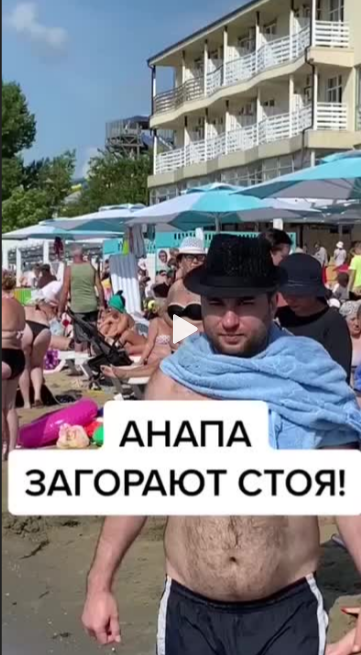

Что это безумство или храбрость в разгар эпидемии, - остаётся за рамками данного проекта. В 2020 году в конце зимы я был в Анапе в командировке, и в те доковидные времена пляжи выглядели так:

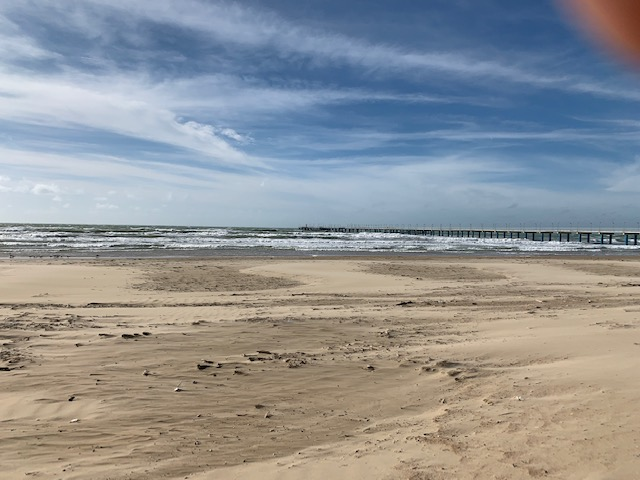

Эта фотография была сделана мной 26 февраля. Как мы видим, отдыхающих нет, можно просто любоваться морем и вдоволь надышаться ветром. Казалось бы, если нет народа, то и нет ажиотажа авиаперевозок в Анапу. Но нет, и в Анапу на Аэробусе А320, и обратно в Шереметьево на Суперджете свободных мест на бортах почти не было. То есть даже зимой это направление востребовано, и значит можно попытаться поиграть в топ-менеджера. Начнём-с.

## Загружаем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

## Предобработка
Считываем датасет, полученный на основе SQL запроса.

In [2]:
data = pd.read_csv('Flight_Unit.csv') # Датасет на основе SQL запроса.
display(data)                         # Посмотрим на него.

,fl_id,dep_air,arr_air,craft_model,flight_duration,pass_count,flight_revenue
0,136119,AAQ,SVO,Boeing 737-300,101.0,113.0,1653000.0
1,136120,AAQ,SVO,Boeing 737-300,99.0,109.0,1605400.0
2,136122,AAQ,SVO,Boeing 737-300,100.0,97.0,1431000.0
3,136130,AAQ,SVO,Boeing 737-300,99.0,107.0,1556600.0
4,136131,AAQ,SVO,Boeing 737-300,99.0,124.0,1812800.0
...,...,...,...,...,...,...,...
188,136943,AAQ,EGO,Sukhoi Superjet-100,50.0,94.0,733800.0
189,136951,AAQ,EGO,Sukhoi Superjet-100,49.0,90.0,720600.0
190,136953,AAQ,EGO,Sukhoi Superjet-100,50.0,97.0,765300.0
191,136956,AAQ,EGO,Sukhoi Superjet-100,50.0,96.0,746400.0


Используемые признаки:
* **fl_id** - идентификатор рейса;
* **dep_air** - аэропорт отправления;
* **arr_air** - аэропорт прибытия;
* **craft_model** - модель самолёта;
* **flight_duration** - длительность полёта в минутах;
* **pass_count** - актуальное количество пассажиров в самолёте;
* **flight_revenue** - доход от продажи билетов, руб.

Также полезно посмотреть.

In [3]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fl_id            193 non-null    int64  
 1   dep_air          193 non-null    object 
 2   arr_air          193 non-null    object 
 3   craft_model      193 non-null    object 
 4   flight_duration  193 non-null    float64
 5   pass_count       180 non-null    float64
 6   flight_revenue   180 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 10.7+ KB


,fl_id,flight_duration,pass_count,flight_revenue
count,193.000000,193.000000,180.000000,1.800000e+02
mean,136540.466321,90.538860,101.950000,1.179647e+06
std,249.389171,62.864684,14.423086,4.811836e+05
min,136119.000000,49.000000,64.000000,5.310000e+05
25%,136320.000000,50.000000,93.000000,7.385250e+05
50%,136534.000000,99.000000,97.000000,1.068850e+06
75%,136768.000000,100.000000,112.250000,1.631950e+06
max,136961.000000,312.000000,130.000000,1.886000e+06



Видно, что присутствуют пропуски по 13 рейсам. Это было видно сразу после выполнения SQL запроса.

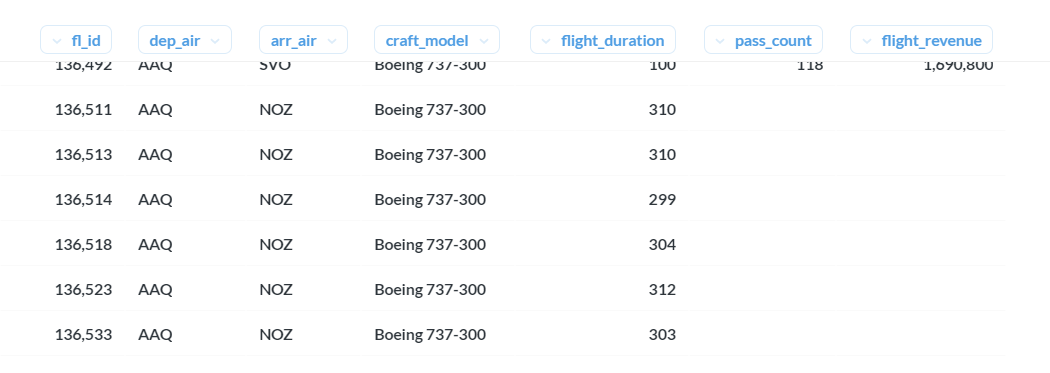

Следует отметить тот факт, что во всех этих рейсах пункт назначения Новокузнецк.

In [4]:
data.isnull().sum() # Убедимся в этом.

fl_id               0
dep_air             0
arr_air             0
craft_model         0
flight_duration     0
pass_count         13
flight_revenue     13
dtype: int64

Выведем их всех на экран, так как на картинке выше всё не поместилось.

In [5]:
data[data.arr_air == 'NOZ']

,fl_id,dep_air,arr_air,craft_model,flight_duration,pass_count,flight_revenue
90,136511,AAQ,NOZ,Boeing 737-300,310.0,NaN,NaN
91,136513,AAQ,NOZ,Boeing 737-300,310.0,NaN,NaN
92,136514,AAQ,NOZ,Boeing 737-300,299.0,NaN,NaN
93,136518,AAQ,NOZ,Boeing 737-300,304.0,NaN,NaN
94,136523,AAQ,NOZ,Boeing 737-300,312.0,NaN,NaN
95,136533,AAQ,NOZ,Boeing 737-300,303.0,NaN,NaN
96,136534,AAQ,NOZ,Boeing 737-300,304.0,NaN,NaN
97,136540,AAQ,NOZ,Boeing 737-300,307.0,NaN,NaN
98,136544,AAQ,NOZ,Boeing 737-300,304.0,NaN,NaN
99,136546,AAQ,NOZ,Boeing 737-300,302.0,NaN,NaN


Тот факт, что данная ситуация происходит только для Боинга с пунктом назначения Новокузнецк, заставляет задуматься, что возможно это не обычный пропуск по причине халатного заполенения БД или сбоя, а что-то запланированное.

Отмечу тот факт, что по роду моей деятельности я часто контактирую со специалистами ОКБ Сухого. Между делом я поинтересовался, что это может значить? Оказывается, есть такое понятие как **_слот_**. Это некое временное окно для взлёта/посадки воздушного судна, которое авиакомпания выкупает. Более подробно можно почитать, например, [тут](https://ru.xcv.wiki/wiki/Landing_slot). Цена слота очень высока и компании могут перепродавать их друг другу. Ниже представлена таблица одних из таких покупок для Хитроу (картинка из вышеуказанной ссылки, и за что компанию Virgin так перевели - вопросы к владельцам сайта :)).

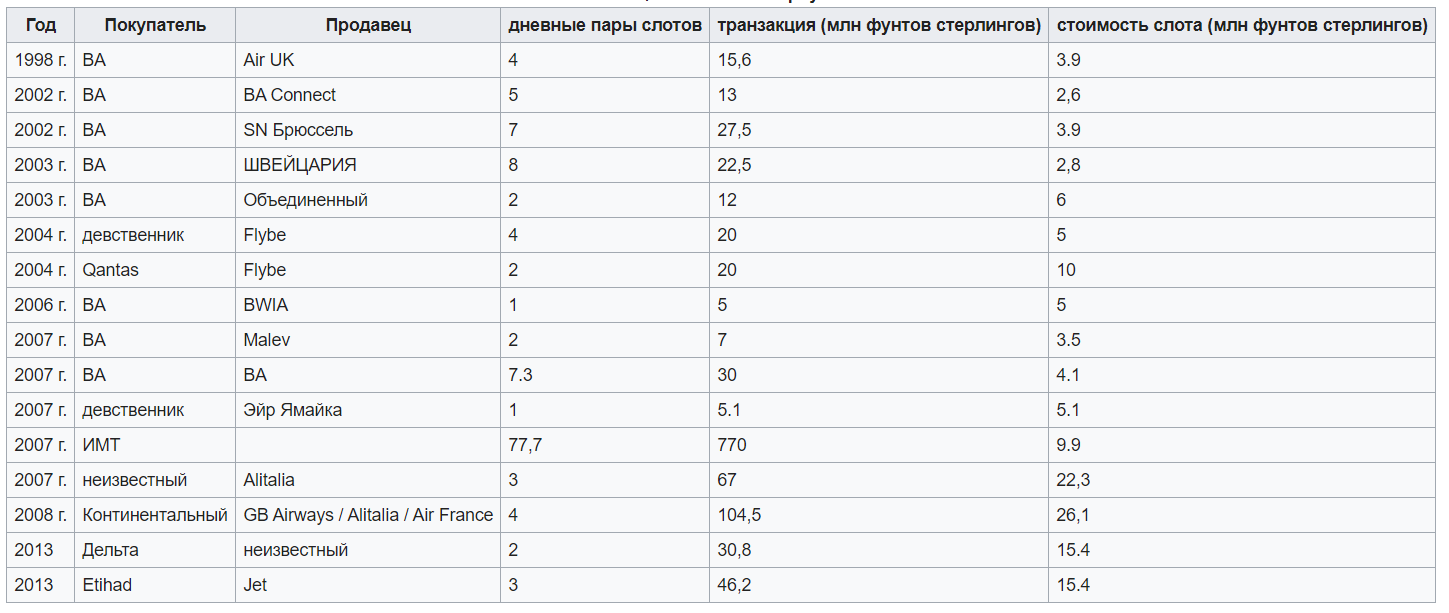

Как видно, суммы очень внушительные. Более того, если авиакомпания не использует выделенные слоты (обычно 80% использования в течение шести месяцев), она может потерять права. Поэтому авиакомпании вынуждены выполнять призрачные или пустые рейсы, чтобы сохранить распределение слотов. Иначе их снова придётся выкупать.

На этом основании я буду считать, что все рейсы Боинга 737-300 в Новокузнецк являются вынужденными рейсами без пассажиров, чтобы не потерять слот. Здесь конечно экономить не получится, с этим придётся мириться и забыть про эти рейсы, поэтому удалим их из датасета.

In [6]:
data = data.dropna();     # Прощай, Новокузнецк..
data = data.reset_index() # Переиндексируем.
del data['index']         # Сносим индексы.
display(data)             # Посмотрим на обновлённый датасет.

,fl_id,dep_air,arr_air,craft_model,flight_duration,pass_count,flight_revenue
0,136119,AAQ,SVO,Boeing 737-300,101.0,113.0,1653000.0
1,136120,AAQ,SVO,Boeing 737-300,99.0,109.0,1605400.0
2,136122,AAQ,SVO,Boeing 737-300,100.0,97.0,1431000.0
3,136130,AAQ,SVO,Boeing 737-300,99.0,107.0,1556600.0
4,136131,AAQ,SVO,Boeing 737-300,99.0,124.0,1812800.0
...,...,...,...,...,...,...,...
175,136943,AAQ,EGO,Sukhoi Superjet-100,50.0,94.0,733800.0
176,136951,AAQ,EGO,Sukhoi Superjet-100,49.0,90.0,720600.0
177,136953,AAQ,EGO,Sukhoi Superjet-100,50.0,97.0,765300.0
178,136956,AAQ,EGO,Sukhoi Superjet-100,50.0,96.0,746400.0


## Дополнительные данные

Поскольку проект называется "Авиарейсы без потерь", следовательно надо будет выяснить причины убытков. Авиакомпания должна не только зарабатывать, но заботиться о своих подчинённых - платить зарплату, разного рода взносы, налоги и так далее. Одним из таких факторов является топливо, которое сложно переоценить. Поэтому для более качественного анализа был подготовлен дополнительный датасет с характеристиками воздушных судов касательно топлива.

In [7]:
plane = pd.read_csv('Plane.csv')  # Загрузка ЛТХ ВС (лётно-технических характеристик воздушных судов).
display(plane)

,craft_model,fuel_rate,spec_frate,max_pass_count
0,Boeing 737-300,2600,25.2,130
1,Sukhoi Superjet-100,1700,21.1,97


Признаки:
* **fuel_rate** - расход топлива в крейсерском режиме, кг/ч;
* **max_pass_count** - пассажировместимость, чел.;
* **spec_frate** - удельный расход топлива, г/(пассажир * км);
* **max_pass_count** - максимальное количество пассажиров.

Свойства топлива брались для нормальных условий. Иформация бралась тут: [Boeing](http://www.boeing.com/assets/pdf/commercial/airports/acaps/737.pdf) и [SSJ100](http://superjet.wikidot.com/wiki:rashod-topliva).

In [8]:
# Обновляем исходный датасет новой информацией по полю craft_model.
data = data.merge(plane, on='craft_model')

In [9]:
# Что получилось?
data.sample(10)

,fl_id,dep_air,arr_air,craft_model,flight_duration,pass_count,flight_revenue,fuel_rate,spec_frate,max_pass_count
31,136257,AAQ,SVO,Boeing 737-300,100.0,111.0,1628600.0,2600,25.2,130
24,136223,AAQ,SVO,Boeing 737-300,101.0,121.0,1751800.0,2600,25.2,130
47,136318,AAQ,SVO,Boeing 737-300,102.0,104.0,1544400.0,2600,25.2,130
123,136733,AAQ,EGO,Sukhoi Superjet-100,51.0,94.0,746400.0,1700,21.1,97
5,136132,AAQ,SVO,Boeing 737-300,99.0,116.0,1714000.0,2600,25.2,130
147,136823,AAQ,EGO,Sukhoi Superjet-100,51.0,78.0,620400.0,1700,21.1,97
153,136855,AAQ,EGO,Sukhoi Superjet-100,50.0,87.0,702300.0,1700,21.1,97
168,136911,AAQ,EGO,Sukhoi Superjet-100,50.0,87.0,676500.0,1700,21.1,97
114,136688,AAQ,EGO,Sukhoi Superjet-100,50.0,89.0,689700.0,1700,21.1,97
11,136164,AAQ,SVO,Boeing 737-300,99.0,120.0,1738400.0,2600,25.2,130



## Расходы.

С доходами довольно таки всё понятно, это проданные билеты. Пришло поговорить о расходах. На основании материалов сайта http://bricsmagazine.com/ru/articles/ekonomika-poleta известно:

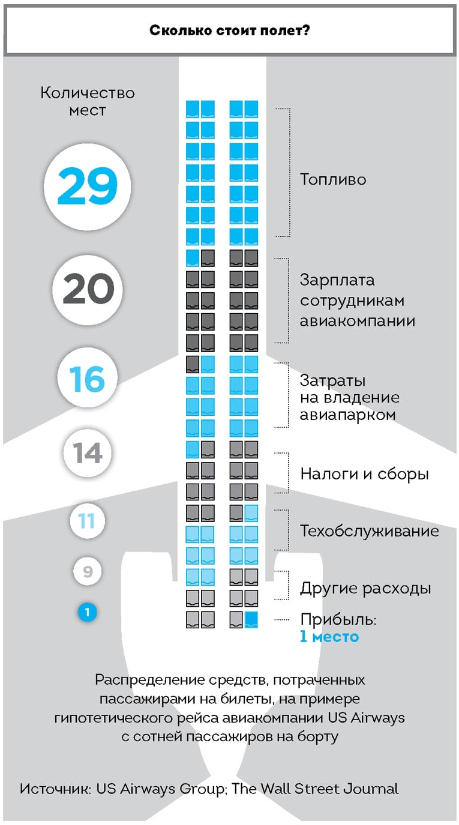

То есть основные расходы таковы:
* 29% - Топливо;
* 20% - Зарплата;
* 16% - Владение авиапарком (лизинг, покупка новых ВС)
* 14% - Налоги и сборы;
* 11% - Техобслуживание;
* 9% - Другие расходы (обеспечение питания например сюда же входит);
* Один процент прибыли?!

Собственно, тут уже можно заканчивать исследования, всего лишь взять 1% от цены на билеты, и вот она прибыль. Но я считаю, что не всё так просто. Ведь в этом случае любой рейс всегда будет прибыльным и задача теряет смысл. Также следует отметить тот факт, что от количества пассажиров зависит и расход топлива. Поэтому я решил, что расходы на топливо как и прибыль следует оценивать из других соображений. Из выше приведённой информации для дальнейших построений берутся все затраты в их процентном соотношении к проданным билетам, за исключением затрат на топливо.




## Топливо
Итак, самый большая доля, как и ожидалось, это затраты на топливо. Повторюсь, с одной стороны данные затраты можно посчитать на основе количества пассажиров и проданных билетов. То есть, образно говоря, взять почти 1/3 от суммы проданных билетов. Но на мой взгляд это будет не совсем корректная математическая модель убытков. Так например, если будет всего один пассажир, то получается затраты на топливо будут минимальны. Но это абсурд, так как вспоминая про рейсы "порожняком", получится, что полёт вообще бесплатен. Поэтому приходится учитывать то топливо, которое ВС предопределённо тратит в любом случае, так и в зависимости от количества пассажиров.
Также следует понимать, что ВС заправляют с запасом на непредвиденные обстоятельства. Вот что говорит Википедия в статье [Дальность полёта летательного аппарата](https://ru.wikipedia.org/wiki/%D0%94%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%BF%D0%BE%D0%BB%D1%91%D1%82%D0%B0_%D0%BB%D0%B5%D1%82%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BF%D0%BF%D0%B0%D1%80%D0%B0%D1%82%D0%B0):

**_"Аэронавигационный запас топлива (АЗТ) составляет, как правило,10-15 % от массы заправляемого топлива."_**

Дополнительно там же:

**_"Наличие невырабатываемого остатка (НОТ) связано с тем, что не всё заправленное в баки самолёта топливо может быть выработано, что связано с конструктивными особенностями топливной системы. Обычно невырабатываемый остаток топлива составляет 1,5 % от массы заправляемого топлива."_**

То есть, в качестве гарантированных убытков можно рассматривать только 88.5% затрат на топливо, принимая в качестве запаса топлива 10%.
Или другими словами к прямым топливным затратам я отношу процессы рулёжки по ВПП, разгона и отрыва, набора высоты, крейсерский режим, подход к аэродрому места назначения и снижение, посадка и снова рулёжка. На мой взгляд это корректно, так как любой полёт не обходится без этих стадий (конечно, здесь я рассматирваю штатные ситуации, без повторных заходов на посадку и уж тем более без авиационных происшествий).


Такой процент АЗТ я принял из соображений, что полёт максимум длится час сорок, на пути следования несколько городов, где есть аэропорты (например Воронеж), летим не над морем. Поэтому 10% вполне должно хватить. Дополнительный плюс - снижение расходов, у нас же "Авиарейсы без потерь".
Давайте наглядно представим соотношение вышеуказанных долей.

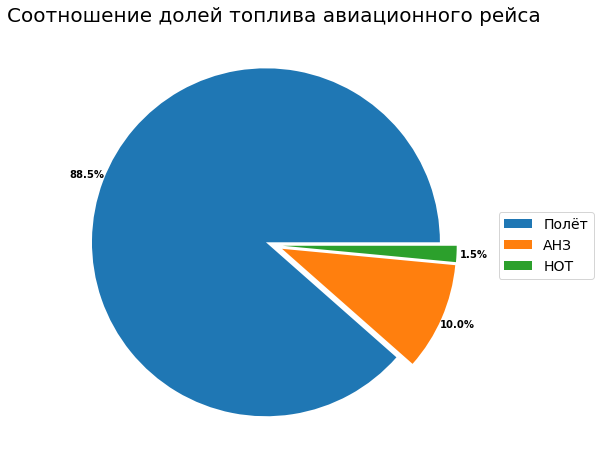

In [10]:
fuel_part = {'Полёт': 88.5, 'АНЗ': 10, 'НОТ': 1.5 }
struct = pd.Series(fuel_part)
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(x=struct, autopct="%.1f%%", explode=[0.05]*3, 
                                                            pctdistance=1.1);
ax.legend(wedges, fuel_part.keys(), loc="center left", bbox_to_anchor=(1, 0., 0.5, 1),
                                                                  fontsize=14)
plt.setp(autotexts, size=10, weight="bold")
ax.set_title(
    'Соотношение долей топлива авиационного рейса',
    fontsize=20);

## **Но тем не менее, заправляться всё равно придётся на 100%!**
Почему? Потому что я не знаю откуда у меня прилетел самолёт, сколько у него топлива, сколько долить, или вообще не заправлять его. Чтобы была хоть какая-то определённость, считаю этот вариант приемлемым.

А теперь ответ на вопрос: "Почему я так привязался к прямым затратам на топливо?". Да потому что, на основе расстояния между Анапой и другим городом, удельного расхода топлива, количества пассажиров можно и т.д. восстановить оценку полных затрат на топливо:

$Fuel_{full} = Fuel_{fly}\;/\;0.885 $

В виду того, что у меня отсутствует полная информация о полёте (расход топлива на каждый момент времени) и нет возможности восстановить её, я буду считать, что ВС летит всегда с крейсерской скоростью от Анапы до пункта назначения.

Продолжим..
Массу "полётного" топлива (те самые 88.5%), можно представить в виде суммы топливного тоннажа для пустого рейса и топливного тоннажа, зависящего от количества пассажиров:

$Fuel_{fly} = Fuel_{fly}^{0} + Fuel_{fly}^{p} = (flight\_duration\;/\;60) * fuel\_rate + spec\_frate * 10^{-3} * pass\_count * distance,\; $

где $Fuel_{fly}^{0}$ - тоннаж для пустого полёта;
$Fuel_{fly}^{p}$ - тоннаж для ВС с **_p_** пассажирами на борту;
$flight\_duration$ - продолжительность полёта в часах;
$fuel\_rate$ - расход топлива;
$spec\_frate$ - удельный расход топлива на одного пассажира;
$pass\_count$ - количество пассажиров на борту ВС;
$distance$ - расстояние между Анапой и Шереметьево или Белгородом.

В этой формуле у нас не хватает расстояния, его можно взять либо из гугл карт, либо из яндекс карт, кому как угодно.
Я беру напрямую расстояние, и с целью упрощения считаю, что ВС летит по прямой, не огибая возможные ледяные тучи, области сильной турбулентности и различные военные объекты.

Итак, от Анапы до Москвы 1200 км, до Белгорода 640 км.
Дополним наш датасет новой информацией.


In [11]:
data["distance"] = data["arr_air"].apply(lambda x: 1200 if x=='SVO' else 640)
data.head()

,fl_id,dep_air,arr_air,craft_model,flight_duration,pass_count,flight_revenue,fuel_rate,spec_frate,max_pass_count,distance
0,136119,AAQ,SVO,Boeing 737-300,101.0,113.0,1653000.0,2600,25.2,130,1200
1,136120,AAQ,SVO,Boeing 737-300,99.0,109.0,1605400.0,2600,25.2,130,1200
2,136122,AAQ,SVO,Boeing 737-300,100.0,97.0,1431000.0,2600,25.2,130,1200
3,136130,AAQ,SVO,Boeing 737-300,99.0,107.0,1556600.0,2600,25.2,130,1200
4,136131,AAQ,SVO,Boeing 737-300,99.0,124.0,1812800.0,2600,25.2,130,1200


На текущем этапе мы уже можем посчитать необходимый тоннаж. Само собой керосин стоит денег, но и заправка есть труд, а любой труд должен быть оплачен. Что у нас есть? Аэропорт в Витязево обслуживает компания [БАТО](www.bato.aero). На сайте довольно легко можно найти стоимость топлива на каждый зимний день 2016-2017 годов, а так же стоимость заправки с учётом НДС (раздел "Раскрытие информации"). На момент времени 2016-2017 годы НДС составлял 18%. Поскольку я оперирую данными за тот же период, то я буду считать, что НДС=18%.

Следует понимать, что я сделал множество допущений (летим напрямую, расход всегда один и тот же и т.д.), то целесообразней использовать стоимость топлива + стоимость заправки не за каждый день, а выбрать что-то среднее, медиану например.

In [12]:
data_fuel = pd.read_csv('Fuel.csv') # Загружаем информацию с сайта БАТО.
data_fuel.sample(10)                # Посмотрим.

,date,fuel_cost,fuelling_cost,fuel_cost_VAT,fuelling_cost_VAT,total_cost
27,28.12.2016,36560,1752,43141,2068,45209
68,07.02.2017,33390,1752,39401,2068,41469
0,01.12.2016,35020,1752,41324,2068,43392
58,28.01.2017,35590,1752,41997,2068,44065
28,29.12.2016,36560,1752,43141,2068,45209
46,16.01.2017,35590,1752,41997,2068,44065
52,22.01.2017,35590,1752,41997,2068,44065
34,04.01.2017,32990,1752,38929,2068,40997
51,21.01.2017,35590,1752,41997,2068,44065
78,17.02.2017,33390,1752,39401,2068,41469


Здесь:
* **date** - дата;
* **fuel_cost** - цена 1 тонны топлива;
* **fuelling_cost** - стоимость заправки;
* **fuel_cost_VAT** - цена 1 тонны топлива с НДС (18%);
* **fuelling_cost_VAT** - цена заправки с НДС (18%;)
* **total_cost** - общая стоимость.

In [13]:
data_fuel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               90 non-null     object
 1   fuel_cost          90 non-null     int64 
 2   fuelling_cost      90 non-null     int64 
 3   fuel_cost_VAT      90 non-null     int64 
 4   fuelling_cost_VAT  90 non-null     int64 
 5   total_cost         90 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 4.3+ KB


Пропусков нет.

Медиана полной суточной стоимости тонны топлива с НДС
44065 рублей.


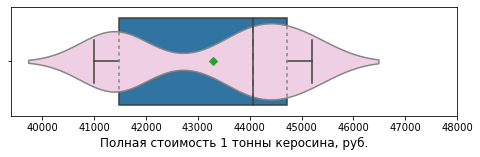

In [14]:
# Рассчитаем цену заправки тонны керосина и посмотрим на распределение.
fuel_cost_day = data_fuel.total_cost.median()
print(f'Медиана полной суточной стоимости тонны топлива с НДС')
print(f'{int(fuel_cost_day)} рублей.')

fig, ax = plt.subplots(figsize=(8,2))
mean_props = dict(marker='D')
sns.boxplot(x="total_cost", data=data_fuel,showmeans=True, meanprops=mean_props)

# Плотность распределения (скрипка).
sns.violinplot(x=data_fuel.total_cost, width=0.7, palette="Pastel2_r",
               scale="count", inner='quartile')

ax.set_xticks(range(40000, 49000, 1000))
ax.set_xlabel('Полная стоимость 1 тонны керосина, руб.', fontsize=12);

На основании выше сделанных выкладок можно принять, что общие затраты отдельно взятого рейса на топливо составляет:
$Fuel\_cost = Fuel_{full} * (fuel\_cost + fuelling\_cost) * 10^{-3} = 0.885 * Fuel_{fly} * (fuel\_cost + fuelling\_cost) * 10^{-3},\;руб.$,  

где $fuel\_cost$ - стоимость топлива (руб./т), $fuelling\_cost$ - оплата услуги по заправке с учётом НДС (руб./т).

## Зарплата

Выше было показано, что на втором месте по затратам стоит зарплата экипажу и прочим сотрудникам, которая составляет 20% от продажи билетов при полной загрузке. Все работают в любом случае, пустой самолёт или нет, поэтому зарплату предлагаю оставить фиксированной. Рассчитаем зарплату для экипажей Боинга и SSJ100.

In [15]:
# Фиксированная зарплата экипажа SSJ100.
wage_SU9 = data.query('pass_count==max_pass_count \
            & craft_model=="Sukhoi Superjet-100"').flight_revenue.max() * 0.2

# Фиксированная зарплата экипажа Boeing.
wage_737 = data.query('pass_count==max_pass_count \
            & craft_model=="Boeing 737-300"').flight_revenue.max() * 0.2

print('Зарплата экипажа:')
print(f'Boeing 737-300: {int(wage_737)}, руб.,')
print(f'Sukhoi Superjet-100: {int(wage_SU9)}, руб.')

Зарплата экипажа:
Boeing 737-300: 377200, руб.,
Sukhoi Superjet-100: 153060, руб.


## Владение авиапарком

По аналогии с зарплатой рассчитаем затраты на покупку новых бортов, лизинг и т.д.

In [16]:
# Фиксированная величина затрат на владение авиапарком SSJ100.
owner_SU9 = data.query('pass_count==max_pass_count \
            & craft_model=="Sukhoi Superjet-100"').flight_revenue.max() * 0.16

# Фиксированная величина затрат на владение авиапарком Boeing.
owner_737 = data.query('pass_count==max_pass_count \
            & craft_model=="Boeing 737-300"').flight_revenue.max() * 0.16

print('Затраты за владение авиапарком:')
print(f'Boeing 737-300: {int(owner_737)}, руб.,')
print(f'Sukhoi Superjet-100: {int(owner_SU9)}, руб.')

Затраты за владение авиапарком:
Boeing 737-300: 301760, руб.,
Sukhoi Superjet-100: 122448, руб.


## Налоги и сборы

Аналогично

In [17]:
# Фиксированная величина затрат на налоги SSJ100.
taxes_SU9 = data.query('pass_count==max_pass_count \
            & craft_model=="Sukhoi Superjet-100"').flight_revenue.max() * 0.14

# Фиксированная величина затрат на налоги Boeing.
taxes_737 = data.query('pass_count==max_pass_count \
            & craft_model=="Boeing 737-300"').flight_revenue.max() * 0.14

print('Налоги и сборы:')
print(f'Boeing 737-300: {int(taxes_737)}, руб.,')
print(f'Sukhoi Superjet-100: {int(taxes_SU9)}, руб.')

Налоги и сборы:
Boeing 737-300: 264040, руб.,
Sukhoi Superjet-100: 107142, руб.


## Техобслуживание

Аналогично

In [18]:
# Фиксированная величина затрат на техобслуживание SSJ100.
service_SU9 = data.query('pass_count==max_pass_count \
            & craft_model=="Sukhoi Superjet-100"').flight_revenue.max() * 0.11

# Фиксированная величина затрат на техобслуживание Boeing.
service_737 = data.query('pass_count==max_pass_count \
            & craft_model=="Boeing 737-300"').flight_revenue.max() * 0.11

print('Техобслуживание:')
print(f'Boeing 737-300: {int(service_737)}, руб.,')
print(f'Sukhoi Superjet-100: {int(service_SU9)}, руб.')

Техобслуживание:
Boeing 737-300: 207460, руб.,
Sukhoi Superjet-100: 84183, руб.


## Прочие расходы

Аналогично

In [19]:
# Фиксированная величина затрат на прочие расходы SSJ100.
other_SU9 = data.query('pass_count==max_pass_count \
            & craft_model=="Sukhoi Superjet-100"').flight_revenue.max() * 0.09

# Фиксированная величина затрат на прочие расходы Boeing.
other_737 = data.query('pass_count==max_pass_count \
            & craft_model=="Boeing 737-300"').flight_revenue.max() * 0.09
#---
print('Прочие расходы:')
print(f'Boeing 737-300: {int(other_737)}, руб.,')
print(f'Sukhoi Superjet-100: {int(other_SU9)}, руб.')

Прочие расходы:
Boeing 737-300: 169740, руб.,
Sukhoi Superjet-100: 68877, руб.


### Расходы на рейс. Итог.

In [20]:
def expenses_calc(aircraft):
    '''
    Функция расчёта затрат с учётом ВС.
    '''
    exp = wage_SU9 + owner_SU9 + taxes_SU9 + service_SU9 + other_SU9
    if aircraft == 'Boeing 737-300':
        exp = wage_737 + owner_737 + taxes_737 + service_737 + other_737
    return exp


# Расходы на топливо.
e_Fuel = data.flight_duration/60 * data.fuel_rate               # Пустая масса.
p_Fuel = data.spec_frate*1e-3 * data.pass_count * data.distance # С пассажирами.
f_Fuel = e_Fuel + p_Fuel                                        # Масса на "полёт" (рулёжка, полёт, взлёт,...).
g_Fuel = f_Fuel / 0.885
fuel_cost = f_Fuel * fuel_cost_day * 1e-3                       # Полная стоимость топлива.

# Общий расход.
cols = ["fl_id", "craft_model", "pass_count", "flight_revenue"]
df = data[cols].copy()
df["cost_tot"] = df["craft_model"].apply(expenses_calc) + fuel_cost # Затраты на рейс.
df["profit"] = df["flight_revenue"] - df["cost_tot"]                # Прибыль.
display(df)

,fl_id,craft_model,pass_count,flight_revenue,cost_tot,profit
0,136119,Boeing 737-300,113.0,1653000.0,1.663633e+06,-10633.209467
1,136120,Boeing 737-300,109.0,1605400.0,1.654484e+06,-49084.140400
2,136122,Boeing 737-300,97.0,1431000.0,1.640403e+06,-209403.316533
3,136130,Boeing 737-300,107.0,1556600.0,1.651819e+06,-95219.089200
4,136131,Boeing 737-300,124.0,1812800.0,1.674472e+06,138327.975600
...,...,...,...,...,...,...
175,136943,Sukhoi Superjet-100,94.0,733800.0,6.540705e+05,79729.529893
176,136951,Sukhoi Superjet-100,90.0,720600.0,6.504417e+05,70158.253267
177,136953,Sukhoi Superjet-100,97.0,765300.0,6.558556e+05,109444.368613
178,136956,Sukhoi Superjet-100,96.0,746400.0,6.552606e+05,91139.422373


## Определим параметры рентабельности

In [21]:
# SSJ100.
SU = "Sukhoi Superjet-100"
fl_time_SU = 50 # Средняя длительность полёта.
max_pass_count_SU = 97 # Пассажиры (макс).
max_revenue_SU = data.query('craft_model==@SU'
                    and 'pass_count==max_pass_count'
                    and 'flight_duration==@fl_time_SU').flight_revenue.max()
rev_pass_SU = max_revenue_SU / max_pass_count_SU # Доход с 1 пассажира.
idx = data.query('craft_model==@SU'
                    and 'pass_count==max_pass_count'
                    and 'flight_duration==@fl_time_SU').flight_revenue.idxmax()
# Расходы.
cost_tot_SU = df.loc[idx, "cost_tot"]

# По аналогии для Boeing 737.
BG = "Boeing 737-300"
fl_time_BG = 100.
max_pass_count_BG = 130 # Пассажиры (макс).
max_revenue_BG = data.query('craft_model==@BG'
                        and 'pass_count==max_pass_count'
                        and 'flight_duration==@fl_time_BG').flight_revenue.max()
rev_pass_BG = max_revenue_BG / max_pass_count_BG
idx = data.query('craft_model==@BG'
                    and 'pass_count==max_pass_count'
                    and 'flight_duration==@fl_time_BG').flight_revenue.idxmax()
# Расходы.
cost_tot_BG = df.loc[idx, "cost_tot"]

Здесь расходы рассчитывались для штатного времени полёта при максимальной загруженности рейса.
Визуализируем результаты.

Количество пассажиров для неотрицательной прибыли:
Boeing 737-300: 116 человек,
Sukhoi Superjet-100:  83 человека.


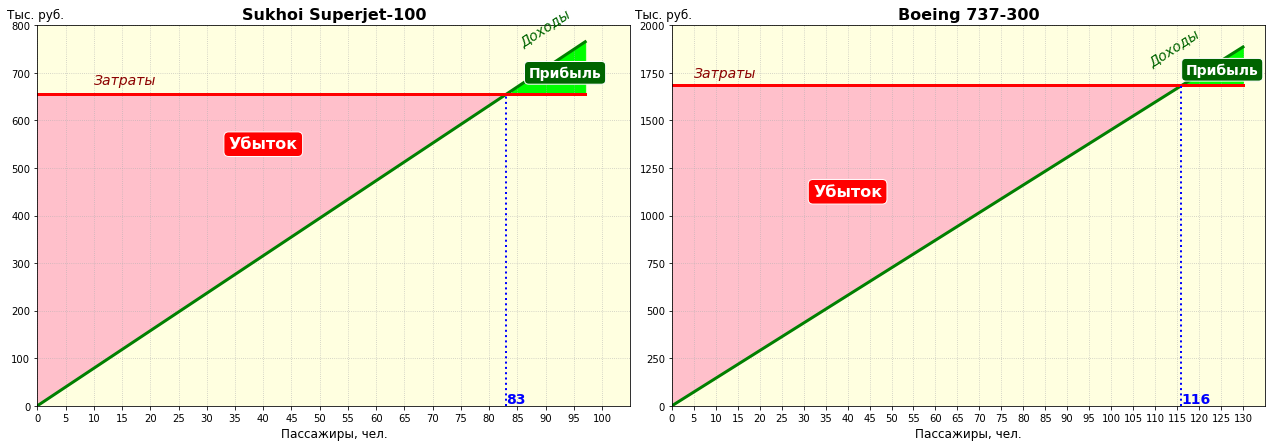

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(22, 7));
[axs.set_facecolor('LightYellow') for axs in ax]
fig.subplots_adjust(wspace=0.07)
[axs.grid(axis = 'both', alpha = 0.75, ls = 'dotted') for axs in ax]

# SSJ100.
ax[0].set_title('Sukhoi Superjet-100', fontweight = 'bold', fontsize = 16)
x = range(0, max_pass_count_SU + 1)
y = np.arange(0, max_revenue_SU + rev_pass_SU, rev_pass_SU)/1e3
ax[0].plot(x, y, ls = '-', lw=3, color = 'g')
ax[0].plot([0, max_pass_count_SU], [cost_tot_SU/1e3, cost_tot_SU/1e3],
           ls = '-', lw=3, c = 'r')
ax[0].fill_between(x, cost_tot_SU/1e3, y, where = (y - cost_tot_SU/1e3) < 0,
                  color='pink')
ax[0].fill_between(x, cost_tot_SU/1e3, y, where = (y - cost_tot_SU/1e3) > 0,
                  color='lime')
ax[0].text(s = 'Затраты', x = 10, y = cost_tot_SU/1e3 + 20, ha = 'left',
           color ='darkred', fontsize=14, style = 'italic')
ax[0].text(s = 'Доходы', x = 85, y = cost_tot_SU/1e3 + 100, ha = 'left',
           color ='darkgreen', fontsize=14, style = 'italic', rotation=33);
ax[0].set_ylabel("Тыс. руб.", rotation=0, position=(0, 1.01), ha="left",
                 fontsize=12);
ax[0].set_xlabel('Пассажиры, чел.', fontsize=12)
ax[0].set_xticks(range(0, 100 + 1, 5))
ax[0].set_xlim([0, 105]); ax[0].set_ylim([0, 800])

props = dict(boxstyle = 'round', fc = 'red', alpha = 1, ec='white')
ax[0].text(s = 'Убыток', x = 40, y = 550, ha = 'center', va = 'center',
           color ='white', bbox=props, fontsize = 16,  fontweight = 'bold')
props = dict(boxstyle = 'round', fc = 'darkgreen', alpha = 1, ec='white')
ax[0].text(s = 'Прибыль', x = 87, y = 700, ha = 'left', va = 'center',
           color ='white',bbox=props, fontsize = 14, fontweight = 'bold');

# Boeing 737.
ax[1].set_title('Boeing 737-300', fontweight = 'bold', fontsize = 16)
x = range(0, max_pass_count_BG + 1)
y = np.arange(0, max_revenue_BG + rev_pass_BG, rev_pass_BG)/1e3
ax[1].plot(x, y, ls = '-', lw=3, color = 'g')
ax[1].plot([0, max_pass_count_BG], [cost_tot_BG/1e3, cost_tot_BG/1e3],
           ls = '-', lw=3, c = 'r')
ax[1].fill_between(x, cost_tot_BG/1e3, y, where = (y - cost_tot_BG/1e3) < 0,
                  color='pink')
ax[1].fill_between(x, cost_tot_BG/1e3, y, where = (y - cost_tot_BG/1e3) > 0,
                  color='lime')
ax[1].text(s = 'Затраты', x = 5, y = cost_tot_BG/1e3 + 40, ha = 'left', 
           color ='darkred', fontsize=14, style = 'italic')
ax[1].text(s = 'Доходы', x = 108, y = cost_tot_BG/1e3 + 100, ha = 'left',
           color ='darkgreen', fontsize=14, style = 'italic', rotation=33);
ax[1].set_ylabel("Тыс. руб.", rotation=0, position=(0, 1.01), ha="left",
                 fontsize=12);
ax[1].set_xlabel('Пассажиры, чел.', fontsize=12)
ax[1].set_xticks(range(0, 130 + 1, 5))
ax[1].set_yticks(range(0, 2000 + 1, 250))
ax[1].set_xlim([0, 135]); ax[1].set_ylim([0, 2000])

props = dict(boxstyle = 'round', fc = 'red', alpha = 1, ec='white')
ax[1].text(s = 'Убыток', x = 40, y = 1125, ha = 'center', va = 'center',
           color ='white', bbox=props, fontsize = 16, fontweight = 'bold')
props = dict(boxstyle = 'round', fc = 'darkgreen', alpha = 1, ec='white')
ax[1].text(s = 'Прибыль', x = 117, y = cost_tot_BG/1e3 + 60, ha = 'left',
           color ='white',bbox=props, fontsize = 14, fontweight = 'bold');

# Критическое число пассажиров.
pass_profit0_SU = cost_tot_SU * max_pass_count_SU / max_revenue_SU
pass_profit0_SU = int(round(pass_profit0_SU, 0))
pass_profit0_BG = cost_tot_BG * max_pass_count_BG / max_revenue_BG
pass_profit0_BG = int(round(pass_profit0_BG, 0))
print('Количество пассажиров для неотрицательной прибыли:')
print(f'Boeing 737-300: {pass_profit0_BG} человек,')
print(f'Sukhoi Superjet-100:  {pass_profit0_SU} человека.')

# Подписи для критического количества пассажиров.
ax[0].plot([pass_profit0_SU, pass_profit0_SU], [0, cost_tot_SU/1e3], ls = ':',
           lw=2, c = 'b')
ax[1].plot([pass_profit0_BG, pass_profit0_BG], [0, cost_tot_BG/1e3], ls = ':',
           lw=2, c = 'b');
ax[0].text(s = f'{pass_profit0_SU}', x = pass_profit0_SU, y = 0, ha = 'left',
           va='bottom', color ='b', fontsize = 14, fontweight = 'bold')
ax[1].text(s = f'{pass_profit0_BG}', x = pass_profit0_BG, y = 0, ha = 'left',
           va='bottom', color ='b', fontsize = 14, fontweight = 'bold');

Выясним и отсеем все нерентабельные рейсы.

In [23]:
abort_flight = df[df.profit<0].shape[0]
print(f'Количество рейсов подлежащих закрытию: {abort_flight}')

Количество рейсов подлежащих закрытию: 65


In [24]:
#pd.set_option('display.max_rows', abort_flight) # Показывать все строки в наборе.
df[df.profit<0]                                 # Посмотрим на них.

,fl_id,craft_model,pass_count,flight_revenue,cost_tot,profit
0,136119,Boeing 737-300,113.0,1653000.0,1.663633e+06,-10633.209467
1,136120,Boeing 737-300,109.0,1605400.0,1.654484e+06,-49084.140400
2,136122,Boeing 737-300,97.0,1431000.0,1.640403e+06,-209403.316533
3,136130,Boeing 737-300,107.0,1556600.0,1.651819e+06,-95219.089200
7,136141,Boeing 737-300,109.0,1603000.0,1.660213e+06,-57212.590400
...,...,...,...,...,...,...
165,136888,Sukhoi Superjet-100,79.0,626100.0,6.451447e+05,-19044.663707
170,136922,Sukhoi Superjet-100,76.0,607800.0,6.433595e+05,-35559.502427
172,136929,Sukhoi Superjet-100,82.0,631800.0,6.469298e+05,-15129.824987
173,136936,Sukhoi Superjet-100,82.0,632400.0,6.469298e+05,-14529.824987


Определим минимальную, среднюю и максимальную прибыль.

In [25]:
profit_min = round(df[df.profit>=0].profit.min(), 0)
profit_mean = round(df[df.profit>=0].profit.mean(), 0)
profit_max = round(df[df.profit>=0].profit.max(), 0)
print('После оптимизации рейсов получим:')
print(f'\tМинимальная прибыль рейса: {int(profit_min)} руб.')
print(f'\tСредняя прибыль рейса: {int(profit_mean)} руб.')
print(f'\tМаксимальная прибыль рейса: {int(profit_max)} руб.')

После оптимизации рейсов получим:
	Минимальная прибыль рейса: 944 руб.
	Средняя прибыль рейса: 89589 руб.
	Максимальная прибыль рейса: 205442 руб.


Проиллюстрируем.

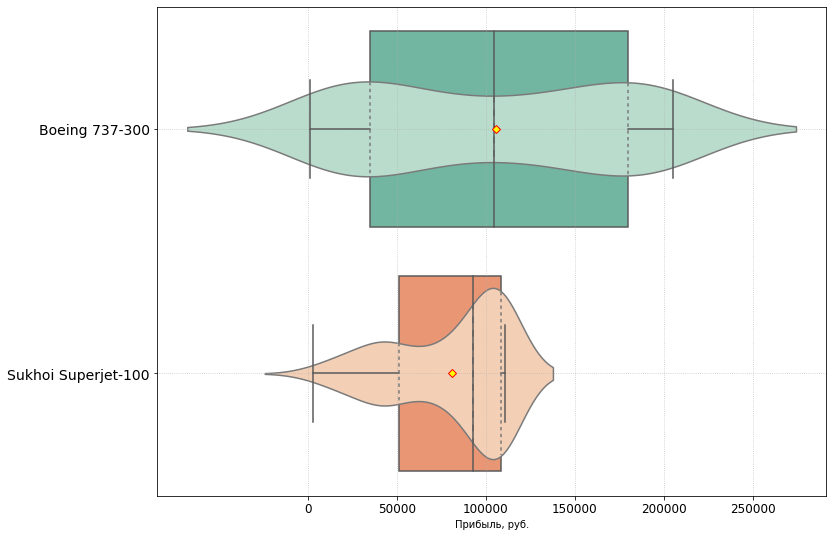

In [26]:
# Построим описательную статистику и плотность распределения
# Ящики с усами и скрипки :)
plt.rcParams.update({
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "xtick.labelsize"      : 12,
        "ytick.labelsize"      : 14,
})

cols = ['craft_model', 'profit']; dff = df[df.profit>=0][cols].copy()
fig, ax = plt.subplots(figsize=(12, 9))

mean_props = dict(marker='D', markeredgecolor='Red',
                  markerfacecolor='Yellow')
sns.boxplot(x="profit", y="craft_model", data=dff, palette="Set2",
            showmeans=True, meanprops=mean_props)
sns.violinplot(x=dff.profit, y=dff.craft_model, width=0.7, palette="Pastel2",
               scale="count", inner='quartile')
#---
ax.grid("both"); ax.set_ylabel(''); ax.set_xlabel('Прибыль, руб.');
ax.set_xticks(range(0, 300000, 50000));

Как видно из графика выше, после оптимизации медиана прибыли для Боинга в районе 105 тыс. рублей за рейс, а для SSJ100 около 85-90 тысяч рублей.

## Выводы

В ходе работы построена модель затрат для каждого рейса в зависимости от загрузки и типа ВС. Определены пороговые значения количества пассажиров для каждого ВС. Определены убыточные рейсы, которые предлагаю закрыть. Также выявлены вынужденные рейсы ввиду правил предоставления слотов.

## P.S.

От себя добавлю, что данная модель на мой взгляд довольно агрессивна ввиду закрытия такого большого числа рейсов. Поскольку считаю, что сделанные допущения по затратам могут быть очень вольными. Но так или иначе, будем считать, что это был план по кризис менеджменту, так как живём в интересное время, что невольно в памяти всплывает шутка из прошлого года :)

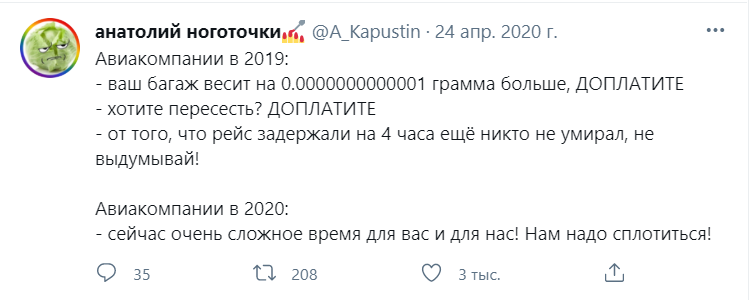

## Большое спасибо за задачу и за Ваше внимание!